# Demo: RasterVision

In [1]:
import autoroot
from typing import Optional, Callable
import toolz 
import functools as ft
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm
from rastervision.core.data import RasterioSource

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-11-21 07:03:30:rastervision.pipeline.rv_config: WARNING - Root temporary directory cannot be used: /opt/data/tmp. Using root: /tmp/tmpbegmp3jv


In [2]:
from helio_tools._src.utils.io import get_list_filenames

base_path = "/home/juanjohn/data/helio/sdo_png/304"
ext = ".png"

data_filenames = get_list_filenames(base_path, ext)
print(len(data_filenames))


50


In [3]:
raster_source = RasterioSource(data_filenames[0], allow_streaming=True)

In [4]:
raster_source.shape

(2048, 2048, 1)

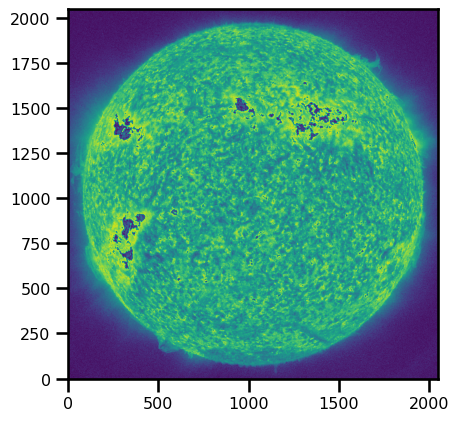

In [5]:
fig, ax = plt.subplots()

ax.imshow(raster_source[:], origin="lower")

plt.show()

## Independent Time Series Images


There is a special case where we have multiple images from a time series but we just assume that they are independent.
In this case, we can just create individual datasets and then concatenate them.

In [6]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from rastervision.core.data import RasterioSource, Scene
from rastervision.pytorch_learner import RegressionRandomWindowGeoDataset, RegressionSlidingWindowGeoDataset

def init_window_random_dataset(
    file: int, 
    window_size: int=256,
    max_windows: int=100,
    efficient_aoi_sampling: bool=True,
    **kwargs
):

    # create raster sources
    rasterio_source = RasterioSource(file, allow_streaming=True)

    filename = Path(file).stem

    # create scene
    scene = Scene(
        id=f"file_{Path(file)}",
        raster_source=rasterio_source, 
    )
    
    ds = RegressionRandomWindowGeoDataset(
        scene=scene, 
        out_size=window_size,
        size_lims=(window_size, window_size + 1),
        max_windows=max_windows,
        efficient_aoi_sampling=efficient_aoi_sampling,
        **kwargs
    )

    return ds

def init_window_stride_dataset(
    file: int, 
    window_size: int=256,
    stride: int=1,
    padding: Optional[int]=None,
    **kwargs
):

    # create raster sources
    rasterio_source = RasterioSource(file, allow_streaming=True)

    filename = Path(file).stem

    # create scene
    scene = Scene(
        id=f"file_{Path(file)}",
        raster_source=rasterio_source, 
    )
    
    ds = RegressionSlidingWindowGeoDataset(
        scene=scene, 
        size=window_size,
        padding=padding, 
        stride=stride,
        **kwargs
    )

    return ds

In [7]:
# create dataset for each file
ds = [init_window_random_dataset(ifile, max_windows=100, efficient_aoi_sampling=True, padding=(0,0)) for ifile in data_filenames]

# concatenate all datasets
ds = ConcatDataset(ds)

# create a dataloader
dl = DataLoader(ds, batch_size=32, shuffle=True)

# create an iterator
ibatch = next(iter(dl))

# print shape
print(ibatch[0].shape)

torch.Size([32, 1, 256, 256])


In [8]:
import torch 

def torch_to_numpy(data: torch.Tensor) -> np.ndarray:
    return data.detach().numpy().transpose(1, 2, 0)

In [9]:
ibatch[0].shape

torch.Size([32, 1, 256, 256])

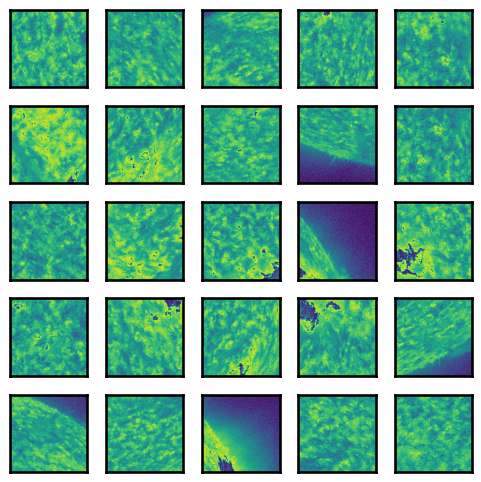

In [10]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5,5))

for idx, iaxes in enumerate(ax.ravel()):
    iaxes.imshow(torch_to_numpy(ibatch[0][idx]))
    iaxes.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()

## Time Series Images

In another case, we can use Rastervision to create a time series image. 

In [11]:
from torch.utils.data import ConcatDataset
from rastervision.pytorch_learner import ImageDataset
from rastervision.core.data import TemporalMultiRasterSource, MultiRasterSource, Scene, Labels
from rastervision.pytorch_learner import RegressionRandomWindowGeoDataset, RegressionSlidingWindowGeoDataset

In [12]:
def init_window_random_ts_dataset(
    files: int, 
    window_size: int=256,
    max_windows: int=100,
    efficient_aoi_sampling: bool=True,
    **kwargs
):

    # create raster sources
    rasterio_sources = [RasterioSource(ifile, allow_streaming=True) for ifile in files]

    # 
    rasterio_source_ts = TemporalMultiRasterSource(
        raster_sources=rasterio_sources
    )

    # create scene
    scene = Scene(
        id="my_scene",
        raster_source=rasterio_source_ts, 
    )
    
    ds = RegressionRandomWindowGeoDataset(
        scene=scene, 
        out_size=window_size,
        size_lims=(window_size, window_size + 1),
        max_windows=max_windows,
        efficient_aoi_sampling=efficient_aoi_sampling,
        **kwargs
    )

    return ds

In [13]:
# initialize ts dataset
ds = init_window_random_ts_dataset(data_filenames[:5], padding=(0,0))

# create a dataloader
dl = DataLoader(ds, batch_size=32, shuffle=True)

# create an iterator
ibatch = next(iter(dl))

# print shape
print(ibatch[0].shape)

torch.Size([32, 5, 1, 256, 256])


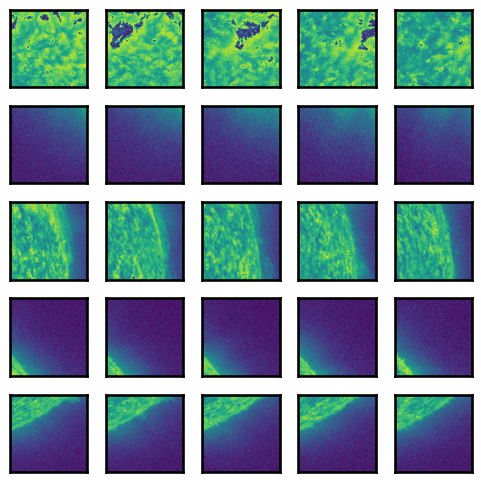

In [14]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(5,5))

for idx, iaxes in enumerate(ax):
    ibatch_ = ibatch[0][idx]
    for idy, iax in enumerate(iaxes):
        iax.imshow(torch_to_numpy(ibatch_[idy]))
        iax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.tight_layout()
plt.show()